# Corona

Novel Corona Virus (COVID-19) epidemiological data since 22 January 2020. The data is compiled by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) from various sources including the World Health Organization (WHO), DXY.cn. Pneumonia. 2020, BNO News, National Health Commission of the People’s Republic of China (NHC), China CDC (CCDC), Hong Kong Department of Health, Macau Government, Taiwan CDC, US CDC, Government of Canada, Australia Government Department of Health, European Centre for Disease Prevention and Control (ECDC), Ministry of Health Singapore (MOH). JSU CCSE maintains the data on the 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository on github. Fields available in the data include Province/State, Country/Region, Last Update, Confirmed, Suspected, Recovered, Deaths.

Data Source: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from matplotlib import colors as mcolors

import warnings, os
import random as rd

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

data_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams.update(plt.rcParamsDefault)

### Loading and Merging the Datasets

In [4]:
# df1 = pd.read_csv('https://data.humdata.org/hxlproxy/data/download/time_series-ncov-Confirmed.csv', encoding = "ISO-8859-1")
# df2 = pd.read_csv('https://data.humdata.org/hxlproxy/data/download/time_series-ncov-Deaths.csv', encoding = "ISO-8859-1")
# df2 = pd.read_csv('https://data.humdata.org/hxlproxy/data/download/time_series-ncov-Recovered.csv', encoding = "ISO-8859-1")

In [5]:
df1 = pd.read_csv(data_path+'\\time_series-ncov-Confirmed.csv', encoding = "ISO-8859-1")
df2 = pd.read_csv(data_path+'\\time_series-ncov-Deaths.csv',    encoding = "ISO-8859-1")
df3 = pd.read_csv(data_path+'\\time_series-ncov-Recovered.csv', encoding = "ISO-8859-1")

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28144 entries, 0 to 28143
Data columns (total 6 columns):
Province/State    19117 non-null object
Country/Region    28144 non-null object
Lat               28144 non-null object
Long              28144 non-null object
Date              28144 non-null object
Value             28144 non-null object
dtypes: object(6)
memory usage: 1.3+ MB


In [7]:
# row with index 0 is a description - dummy row - to be removed

df1.drop(index = 0, axis = 0, inplace = True) 
df2.drop(index = 0, axis = 0, inplace = True)
df3.drop(index = 0, axis = 0, inplace = True)

In [8]:
# drop the latitude, logitude and Province/State columns - the province / state is available only for US

df1.drop(['Lat', 'Long', 'Province/State'], axis = 1, inplace = True)
df2.drop(['Lat', 'Long', 'Province/State'], axis = 1, inplace = True)
df3.drop(['Lat', 'Long', 'Province/State'], axis = 1, inplace = True)

In [9]:
# convert the values to numeric field

df1['Value'] = df1['Value'].astype(int)
df2['Value'] = df2['Value'].astype(int)
df3['Value'] = df3['Value'].astype(int)

In [10]:
# Since we removed the province / state for US multiple entries need to be aggregated - split-apply-combine

df1 = pd.DataFrame(df1.groupby(['Country/Region', 'Date'])['Value'].sum()).reset_index()
df2 = pd.DataFrame(df2.groupby(['Country/Region', 'Date'])['Value'].sum()).reset_index()
df3 = pd.DataFrame(df3.groupby(['Country/Region', 'Date'])['Value'].sum()).reset_index()

In [11]:
# Now we will join these data sets into one

df = df1.merge(df2, on = ['Country/Region', 'Date'], how = 'inner').merge(df3, on = ['Country/Region', 'Date'], how = 'inner')

In [12]:
# Renaming the Value columns as Confirmed, Deaths and Recovered

df.rename(columns = {'Value_x' : 'Confirmed', 
                     'Value_y' : 'Deaths',
                     'Value'   : 'Recovered'}, inplace = True) 

In [13]:
df.rename(columns = {'Country/Region' : 'Country'}, inplace = True)

In [14]:
df['Country'] = df['Country'].astype(str) # Converting Country to String Data type

In [15]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d') # Converting Date to DateTime Data type

In [16]:
df

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0
...,...,...,...,...,...
9553,Zimbabwe,2020-03-16,0,0,0
9554,Zimbabwe,2020-03-17,0,0,0
9555,Zimbabwe,2020-03-18,0,0,0
9556,Zimbabwe,2020-03-19,0,0,0


---

### Feature Engineering

In [17]:
import datetime as dt
from datetime import timedelta

In [18]:
df['Day'] = df['Date'].dt.dayofweek

df['Day'] = df['Day'].map({0: 'Monday', 
                           1: 'Tuesday', 
                           2: 'Wednesday', 
                           3: 'Thursday', 
                           4: 'Friday', 
                           5: 'Saturday', 
                           6: 'Sunday'})

In [19]:
df['Month'] = df['Date'].dt.month_name(locale = 'English')

In [20]:
countries = list(df.Country.unique())

df['Temp'] = df['Confirmed'] // df['Confirmed'] # Identify rows with non-zero values

tempdf = df[['Country', 'Date', 'Temp']].iloc[0:0]

for country in countries:
    country_df = df[df['Country'] == country][['Country', 'Date', 'Temp']]
    country_df['Temp'] = country_df['Temp'].cumsum(axis = 0) // 7 + 1
    tempdf = pd.concat([tempdf, country_df])
    
df = df.merge(tempdf, on = ['Country', 'Date'], how = 'inner')

df.drop(['Temp_x'], axis = 1, inplace = True)

df.rename(columns = {'Temp_y' : 'Week'}, inplace = True)

In [21]:
df

,Country,Date,Confirmed,Deaths,Recovered,Day,Month,Week
0,Afghanistan,2020-01-22,0,0,0,Wednesday,January,NaN
1,Afghanistan,2020-01-23,0,0,0,Thursday,January,NaN
2,Afghanistan,2020-01-24,0,0,0,Friday,January,NaN
3,Afghanistan,2020-01-25,0,0,0,Saturday,January,NaN
4,Afghanistan,2020-01-26,0,0,0,Sunday,January,NaN
...,...,...,...,...,...,...,...,...
9553,Zimbabwe,2020-03-16,0,0,0,Monday,March,NaN
9554,Zimbabwe,2020-03-17,0,0,0,Tuesday,March,NaN
9555,Zimbabwe,2020-03-18,0,0,0,Wednesday,March,NaN
9556,Zimbabwe,2020-03-19,0,0,0,Thursday,March,NaN


In [22]:
df[df['Country'] == 'Italy']

,Country,Date,Confirmed,Deaths,Recovered,Day,Month,Week
4484,Italy,2020-01-22,0,0,0,Wednesday,January,NaN
4485,Italy,2020-01-23,0,0,0,Thursday,January,NaN
4486,Italy,2020-01-24,0,0,0,Friday,January,NaN
4487,Italy,2020-01-25,0,0,0,Saturday,January,NaN
4488,Italy,2020-01-26,0,0,0,Sunday,January,NaN
4489,Italy,2020-01-27,0,0,0,Monday,January,NaN
4490,Italy,2020-01-28,0,0,0,Tuesday,January,NaN
4491,Italy,2020-01-29,0,0,0,Wednesday,January,NaN
4492,Italy,2020-01-30,0,0,0,Thursday,January,NaN
4493,Italy,2020-01-31,2,0,0,Friday,January,1.0


The confirmed, deaths and recovered are cumulative figures in the data set. We need day-wise confirmed, deaths and recovered. This can be obtained by reducing the numbers from the next day's numbers.

In [23]:
df1 = df.copy()
df2 = df.copy()

In [24]:
df1['Date'] = df1['Date'] + timedelta(days=1)

In [25]:
df1 = df1.merge(df2, on = ['Country', 'Date'], how = 'outer')

In [26]:
df1['Confirmed_New'] = df1['Confirmed_y'] - df1['Confirmed_x']
df1['Recovered_New'] = df1['Recovered_y'] - df1['Recovered_x']
df1['Deaths_New']    = df1['Deaths_y']    - df1['Deaths_x']

In [27]:
df1.drop(['Confirmed_x', 'Deaths_x', 'Recovered_x', 'Day_x', 'Month_x',
          'Confirmed_y', 'Deaths_y', 'Recovered_y', 'Day_y', 'Month_y'], axis = 1, inplace = True)

In [28]:
df = df.merge(df1, on = ['Country', 'Date'], how = 'outer')

In [29]:
df[df['Country'] == 'Italy']

,Country,Date,Confirmed,Deaths,Recovered,Day,Month,Week,Week_x,Week_y,Confirmed_New,Recovered_New,Deaths_New
4484,Italy,2020-01-22,0.0,0.0,0.0,Wednesday,January,NaN,NaN,NaN,NaN,NaN,NaN
4485,Italy,2020-01-23,0.0,0.0,0.0,Thursday,January,NaN,NaN,NaN,0.0,0.0,0.0
4486,Italy,2020-01-24,0.0,0.0,0.0,Friday,January,NaN,NaN,NaN,0.0,0.0,0.0
4487,Italy,2020-01-25,0.0,0.0,0.0,Saturday,January,NaN,NaN,NaN,0.0,0.0,0.0
4488,Italy,2020-01-26,0.0,0.0,0.0,Sunday,January,NaN,NaN,NaN,0.0,0.0,0.0
4489,Italy,2020-01-27,0.0,0.0,0.0,Monday,January,NaN,NaN,NaN,0.0,0.0,0.0
4490,Italy,2020-01-28,0.0,0.0,0.0,Tuesday,January,NaN,NaN,NaN,0.0,0.0,0.0
4491,Italy,2020-01-29,0.0,0.0,0.0,Wednesday,January,NaN,NaN,NaN,0.0,0.0,0.0
4492,Italy,2020-01-30,0.0,0.0,0.0,Thursday,January,NaN,NaN,NaN,0.0,0.0,0.0
4493,Italy,2020-01-31,2.0,0.0,0.0,Friday,January,1.0,NaN,1.0,2.0,0.0,0.0


In [30]:
curr_date = dt.datetime.today().strftime("%Y-%m-%d")

In [31]:
df = df[df['Date'] != curr_date]

---

In [32]:
watchlist = ['Italy', 'India']

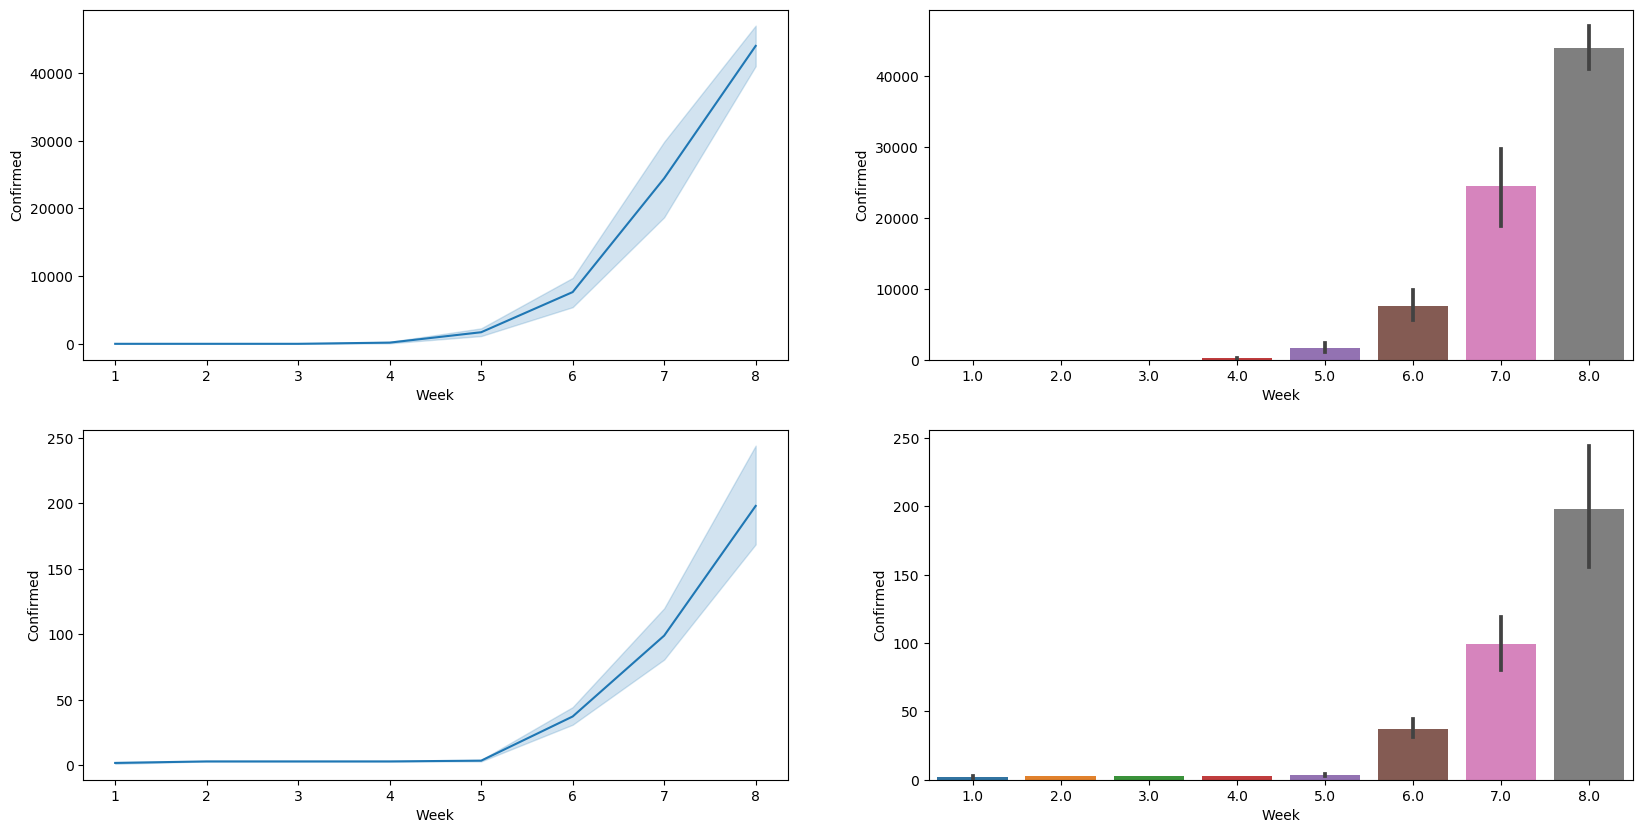

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

i = 0

for country in watchlist:
    
    sns.lineplot(data = df[df['Country'] == country], x = 'Week', y = 'Confirmed', ax = axes[i][0])
    sns.barplot(data = df[df['Country'] == country], x = 'Week', y = 'Confirmed', ax = axes[i][1])
    i = i + 1
        
plt.show()

In [34]:
sns.barplot(data = df[df['Country'] == 'India'], x = 'Week', y = 'Confirmed')

In [35]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cruise Ship',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ire

In [36]:
print(len(countries))

162


In [37]:
print(162/4)

40.5


In [38]:
df[df['Country'] == 'China']

,Country,Date,Confirmed,Deaths,Recovered,Day,Month,Week,Week_x,Week_y,Confirmed_New,Recovered_New,Deaths_New
1888,China,2020-01-22,548.0,17.0,28.0,Wednesday,January,1.0,NaN,1.0,NaN,NaN,NaN
1889,China,2020-01-23,643.0,18.0,30.0,Thursday,January,1.0,1.0,1.0,95.0,2.0,1.0
1890,China,2020-01-24,920.0,26.0,36.0,Friday,January,1.0,1.0,1.0,277.0,6.0,8.0
1891,China,2020-01-25,1406.0,42.0,39.0,Saturday,January,1.0,1.0,1.0,486.0,3.0,16.0
1892,China,2020-01-26,2075.0,56.0,49.0,Sunday,January,1.0,1.0,1.0,669.0,10.0,14.0
1893,China,2020-01-27,2877.0,82.0,58.0,Monday,January,1.0,1.0,1.0,802.0,9.0,26.0
1894,China,2020-01-28,5509.0,131.0,101.0,Tuesday,January,2.0,1.0,2.0,2632.0,43.0,49.0
1895,China,2020-01-29,6087.0,133.0,120.0,Wednesday,January,2.0,2.0,2.0,578.0,19.0,2.0
1896,China,2020-01-30,8141.0,171.0,135.0,Thursday,January,2.0,2.0,2.0,2054.0,15.0,38.0
1897,China,2020-01-31,9802.0,213.0,214.0,Friday,January,2.0,2.0,2.0,1661.0,79.0,42.0
